### Homework #8: Variational Autoencoders (VAE)
#### Luke Schwenke
#### Machine Learning & Predictive Analytics 
#### May 27, 2023

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img

#### Create a sampling layer

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#### Build the encoder

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(200, 200, 3)) # dimensions of input images 200x200
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x) #200?
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 50, 50, 64)   18496       ['conv2d[0][0]']                 
                                                                                            

#### Build the decoder

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50 * 50 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((50, 50, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 160000)            480000    
                                                                 
 reshape (Reshape)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 100, 100, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 200, 200, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 200, 200, 3)      867 

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## 1. Train VAE

Fit the VAE model using one of the 2 pictures, call it pic_1.
Trim the picture to fit the input 200-by-200 dimensions using

In [6]:
upload_pic_1 = load_img('pic_1.jpg')
upload_pic_2 = load_img('pic_2.jpg')

In [7]:
pic_1 = np.expand_dims(upload_pic_1, 0).astype("float32") / 255
pic_1 = pic_1[:,-201:-1, 0:200]

pic_2 = np.expand_dims(upload_pic_2, 0).astype("float32") / 255
pic_2 = pic_2[:,-201:-1, 0:200]

In [8]:
print(pic_1.shape)
print(pic_2.shape)

(1, 200, 200, 3)
(1, 200, 200, 3)


In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(pic_1, epochs=30, batch_size=128)

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 27723.9238 - reconstruction_loss: 27723.9023 - kl_loss: 0.0214
Epoch 2/30
1/1 [==============================] - 0s 45ms/step - loss: 27740.0391 - reconstruction_loss: 27604.7930 - kl_loss: 135.2459
Epoch 3/30
1/1 [==============================] - 0s 45ms/step - loss: 27618.9355 - reconstruction_loss: 27609.1992 - kl_loss: 9.7365
Epoch 4/30
1/1 [==============================] - 0s 46ms/step - loss: 27612.7910 - reconstruction_loss: 27610.6484 - kl_loss: 2.1427
Epoch 5/30
1/1 [==============================] - 0s 47ms/step - loss: 27447.3828 - reconstruction_loss: 27445.9746 - kl_loss: 1.4078
Epoch 6/30
1/1 [==============================] - 0s 46ms/step - loss: 27384.1484 - reconstruction_loss: 27377.1875 - kl_loss: 6.9613
Epoch 7/30
1/1 [==============================] - 0s 46ms/step - loss: 27371.9727 - reconstruction_loss: 27327.2910 - kl_loss: 44.6820
Epoch 8/30
1/1 [==============================] - 0s 47ms/ste

## 2. Sample the latent space

In [10]:
def sample_latent_space(input):
    z_mean, z_log_var, _ = input 
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

sls = sample_latent_space(encoder.predict(pic_1))
print(sls)

1/1 [==============================] - 0s 80ms/step
tf.Tensor([[ 5.633427  -4.0745296]], shape=(1, 2), dtype=float32)


In [11]:
encoder.predict(pic_1)

1/1 [==============================] - 0s 15ms/step


[array([[ 5.9966383, -4.049434 ]], dtype=float32),
 array([[ 2.7095833, -6.181904 ]], dtype=float32),
 array([[ 7.945616, -3.929776]], dtype=float32)]

#### Sample Function - Explanation

* Line 1 (Define) - The input in the function above is the image array of numeric values after being passed through the encoder. In this case we pass the encoder prediction of the picture into the input. The result of this encoding is a 2-D array. 

* Line 2 - From the result, we retrieve the mean and logarithm of the variance from the distribution that we want to sample.

* Line 3 - The batch variable represents the batch size from the z_mean and z_log_var tensors

* Line 4 - The dim variable represents the dimensionality from the z_mean and z_log_var tensors

* Line 5 - The epsilon variable generates a random tensor of shape batch and dim from a normal distribution. This creates random noise to be introducted into the process.

* Line 6 (Return) - The last line returns the sample value from the distribution by adding the mean to the random noise we created in line 5 multiplied by the standard deviation of the distribution. **Mean + Noise * Standard Deviation = Sample**

## 3. Generate Images

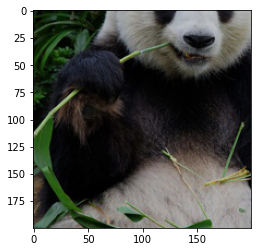

In [12]:
def show_image(img):
    # Remove the singleton dimension
    image_array = np.squeeze(img, axis=0)

    # Rescale the pixel values to the range [0, 200]
    image_array = (image_array * 200).astype(np.uint8)

    plt.imshow(image_array)

show_image(pic_1)

1/1 [==============================] - 0s 15ms/step
Z_mean & Z_log_var: [[ 5.9966383 -4.049434 ]] [[ 2.7095833 -6.181904 ]]

Encoded Images: [[ 9.473273 -4.037261]]
1/1 [==============================] - 0s 73ms/step

Decoded Image Shape: (1, 200, 200, 3)


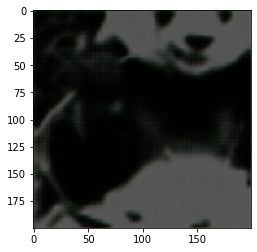

In [13]:
# Run 1
z_mean, z_log_var, encoded_imgs = encoder.predict(pic_1)

print('Z_mean & Z_log_var:', z_mean, z_log_var)
print('\nEncoded Images:', encoded_imgs)

decoded_imgs = decoder.predict(encoded_imgs)
print('\nDecoded Image Shape:', decoded_imgs.shape)
show_image(decoded_imgs)

1/1 [==============================] - 0s 15ms/step
Z_mean & Z_log_var: [[ 5.9966383 -4.049434 ]] [[ 2.7095833 -6.181904 ]]

Encoded Images: [[12.243059 -4.008545]]
1/1 [==============================] - 0s 22ms/step

Decoded Image Shape: (1, 200, 200, 3)


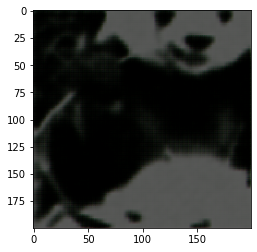

In [14]:
# Run 2
z_mean, z_log_var, encoded_imgs = encoder.predict(pic_1)

print('Z_mean & Z_log_var:', z_mean, z_log_var)
print('\nEncoded Images:', encoded_imgs)

decoded_imgs = decoder.predict(encoded_imgs)
print('\nDecoded Image Shape:', decoded_imgs.shape)
show_image(decoded_imgs)

1/1 [==============================] - 0s 18ms/step
Z_mean & Z_log_var: [[ 5.9966383 -4.049434 ]] [[ 2.7095833 -6.181904 ]]

Encoded Images: [[ 6.4238405 -4.0164156]]
1/1 [==============================] - 0s 23ms/step

Decoded Image Shape: (1, 200, 200, 3)


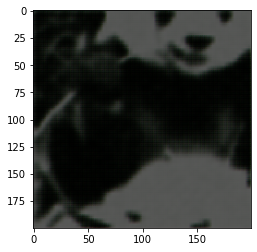

In [15]:
# Run 3
z_mean, z_log_var, encoded_imgs = encoder.predict(pic_1)

print('Z_mean & Z_log_var:', z_mean, z_log_var)
print('\nEncoded Images:', encoded_imgs)

decoded_imgs = decoder.predict(encoded_imgs)
print('\nDecoded Image Shape:', decoded_imgs.shape)
show_image(decoded_imgs)

## New Input Data

(300, 300)
(1, 200, 200, 3)


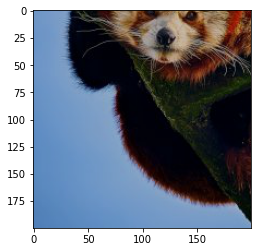

In [16]:
# loading the image
img = load_img('pic_2.jpg')
print(img.size)

pic_2 = np.expand_dims(img, 0).astype("float32") / 255
pic_2 = pic_2[:,-201:-1, 0:200]
print(pic_2.shape)

show_image(pic_2)

1/1 [==============================] - 0s 15ms/step
Z_mean & Z_log_var: [[ 6.615705  -4.4587445]] [[ 2.99002  -6.899698]]

Encoded Images: [[ 8.57605   -4.5207205]]
1/1 [==============================] - 0s 23ms/step

Decoded Image Shape: (1, 200, 200, 3)


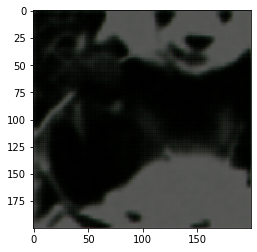

In [17]:
# Picture 2
z_mean, z_log_var, encoded_imgs = encoder.predict(pic_2)

print('Z_mean & Z_log_var:', z_mean, z_log_var)
print('\nEncoded Images:', encoded_imgs)

decoded_imgs = decoder.predict(encoded_imgs)
print('\nDecoded Image Shape:', decoded_imgs.shape)
show_image(decoded_imgs)

#### Result Explanation
When picture two was run through the Variational Auto-Encoder the image was very similar to the first output (black and white panda). There are some slight variations in terms of color and lightness of the pixels. This is because the VAE was trained on a single image and the encoder could therefore not generalize to new images. In this sense the encoder was extremely overfit to picture one.